In [1]:
import gensim
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import pickle
import threading
from IPython.display import clear_output

In [2]:
# exquisite acronym explanation (also sounds like lean):
# R - recurrent
# E - embedding
# A - approximation
# N - network

In [3]:
# embeddings mode
model_file = fr"./embedding_models/wiki_model3.model"
embeddings_model = Word2Vec.load(model_file)
vector_size = embeddings_model.vector_size
window = embeddings_model.window

# neural net settings
segment_size = 6
input_size = vector_size * segment_size
output_size = vector_size * segment_size

# dataset
train_dataset_path = fr"./datasets/wiki_dump_train.txt"
test_dataset_path = fr"./datasets/wiki_dump_test.txt"
unique_examples_train = 4096 * 8 * 3
unique_examples_test = 4096
lerp_steps = 4

# training
epochs = 64
initial_lr = 0.0003
final_lr = 0.00003
gamma = (final_lr / initial_lr) ** (1 / epochs)
loss = nn.MSELoss()
optimizer = torch.optim.Adam
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR
batch_size = 1024#8#16#32#56#1024 * 1

# pytorch
run_device = torch.device("cuda")
storage_device = torch.device("cpu")

In [4]:

class REAN_block(nn.Module):
    def __init__(self, input_size, output_size):
        super(REAN_block, self).__init__()
        self.fc1 = nn.Linear(input_size * 2, 1200)
        self.fc2 = nn.Linear(1200, 1200)
        self.fc3 = nn.Linear(1200, 1200)
        self.fc4 = nn.Linear(1200, output_size)

    def forward(self, prev_block: torch.Tensor, fresh_input: torch.Tensor) -> torch.Tensor:
        batch_given = prev_block.shape[0]
        
        prev_block = prev_block.view(batch_given, segment_size * vector_size)
        fresh_input = fresh_input.view(batch_given, segment_size * vector_size)
        
        x = torch.cat((prev_block, fresh_input), dim=1)
        
        x /= 5
        
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = torch.tanh(self.fc3(x))
        x = self.fc4(x)
        
        x *= 5
        
        # reshape so next block will have correct shape
        x = x.view(batch_given, segment_size, vector_size)
        
        return x

In [5]:
# intake dim: (batch, segment_size, vector_size) x 1
# output dim: (batch, segment_size, vector_size) x 1
class REAN(nn.Module):
    def __init__(self, input_size):
        super(REAN, self).__init__()
        
        self.block1 = REAN_block(input_size, output_size)
        self.block2 = REAN_block(input_size, output_size)
        self.block3 = REAN_block(input_size, output_size)
        self.block4 = REAN_block(input_size, output_size)
        self.block5 = REAN_block(input_size, output_size)
        self.block6 = REAN_block(input_size, output_size)
        self.block7 = REAN_block(input_size, output_size)
        self.block8 = REAN_block(input_size, output_size)

    def forward(self, current_segment: torch.Tensor) -> torch.Tensor:
        # keep x's clone from the start so the blocks get fresh input
        self.fresh_input = current_segment.clone()
        
        current_segment = self.block1(current_segment, self.fresh_input)
        current_segment = self.block2(current_segment, self.fresh_input)
        current_segment = self.block3(current_segment, self.fresh_input)
        current_segment = self.block4(current_segment, self.fresh_input)
        current_segment = self.block5(current_segment, self.fresh_input)
        current_segment = self.block6(current_segment, self.fresh_input)
        current_segment = self.block7(current_segment, self.fresh_input)
        current_segment = self.block8(current_segment, self.fresh_input)
        
        return current_segment

net = REAN(input_size)
net.to(run_device)
optimizer = optimizer(net.parameters(), lr=initial_lr)
scheduler = scheduler(optimizer, T_max=epochs, eta_min=final_lr)

c:\Users\user\anaconda3\envs\CONDA_VENV\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
def lerp(start: float, end: float, progress: float) -> float:
    return start + progress * (end - start)

In [7]:
def load_dataset_chunk(path: str, num_words: int, seek_start: int, sep: str = " ") -> tuple[list, bool, int]:
    """
    function to load a chunk of the dataset where the words are separated by "sep" into a list
    
    parameters:
        path (str): path to the dataset txt file
        num_words (int): number of words to load
        seek_start (int): start char to pull words from
        sep (str, optional): separator in the dataset, defaults to space " "
    
    returns:
        list: list of strings (loaded words), is EOF hit, seek position to move 1 word forward
    """
    
    # some safety checks so later code looks cleaner
    num_words = max(0, num_words)
    seek_start = max(0, seek_start)
    
    words = []
    current_word_idx = 0
    word_buffer = ""
    current_seek = seek_start
    next_seek = 0
    first_word_flag = True

    with open(path, 'r', encoding='utf-8', errors='ignore') as file:
        file.seek(seek_start)
        
        # loop over all chars after seek_start
        while True:
            char = file.read(1)
            current_seek += 1
            
            # end of file, return whatever has been collected immediately
            if not char:
                return words, True, next_seek
            
            # is a separator between words hit
            if char == sep or char.isspace():
                if word_buffer:
                    if current_word_idx < num_words:
                        words.append(word_buffer)
                    
                    current_word_idx += 1
                    word_buffer = ""
                
                if current_word_idx >= num_words:
                    break
                
                # the first word is covered, this is where the next chunk is going to be loaded from
                if first_word_flag:
                    first_word_flag = False
                    next_seek = current_seek
            else:
                word_buffer += char

    return words, False, next_seek

In [8]:
def vectorize_sentence(sentence: list[str], model: Word2Vec, default: int = 0) -> np.ndarray:
    """
    encodes all words in a given list to corresponding vectors in given model.
    words not found in the model will be given a vector with "default" value
    
    parameters:
        sentence (list): list of strings (words)
        model (Word2Vec): model to use when encoding
        default (int): fill vector with this value if word is not found in model
    
    returns:
        np.array: 2d array with dim1 = len(sentence) and dim2 = model.vector_size
    """
    
    # generate inital array with default values
    vectorized = np.ones((len(sentence), model.vector_size)) * default
    
    # loop over every word in list
    for current_word, current_word_idx in zip(sentence, range(len(sentence))):
        # only add correct values if word is in model, otherwise leave as default
        if current_word in model.wv:
            vectorized[current_word_idx] *= 0
            vectorized[current_word_idx] += model.wv[current_word]
    
    return vectorized

In [9]:
def devectorize_sentence(vectorized_sentence: np.array, model: Word2Vec) -> list:
    """
    decodes vectors into nearest word found in model
    
    parameters:
        vectorized_sentence (np.array): 2d arrat with vectors of words to be decoded
        model (Word2Vec): model to use when decoding
    
    returns:
        list: list of strings (words) whos vectors most closely match those provided
    """
    
    result = []
    
    # go over all words and find closest match in model
    for current_word in vectorized_sentence:
        result.append(model.wv.similar_by_vector(current_word)[0][0])
    
    return result

In [10]:
def pad_or_truncate(suspected_tensor: torch.tensor, target_length: int, default: int=0) -> torch.Tensor:
    """
    pads or truncates a given tensor along dim 0 to target_length with "default" as padding
    
    parameters:
        suspected_tensor (torch.tensor): tensor to pad or truncate
        target_length (int): target length of tensor
        default (int): value to use for padding
    
    returns:
        torch.tensor: tensor of proper length no matter what
    """
    
    if len(suspected_tensor) < target_length:
        # pad
        suspected_tensor = torch.cat((torch.ones(target_length - len(suspected_tensor), suspected_tensor.shape[1], dtype=torch.float32, device=suspected_tensor.device) * default, suspected_tensor))
    else:
        # truncate
        suspected_tensor = suspected_tensor[-target_length:]
    
    return suspected_tensor

In [11]:
def prepare_sentence_for_net(sentence: list, model: Word2Vec, context_length: int, flatten: bool=True, used_device: torch.device=run_device) -> torch.Tensor:
    """
    turns a sentence (list of strings) into a tensor that can be fed directly into the network
    
    parameters:
        sentence (list): list of strings (words)
        model (Word2Vec): model to use when encoding sentence
        context_length (int): length of context to consider when encoding, should be same as network's
    
    returns:
        torch.tensor: tensor of proper length no matter what
    """
    
    # encode sentence to np.array
    vectorized = vectorize_sentence(sentence, model)
    vectorized_tensor = torch.from_numpy(vectorized).to(used_device).to(torch.float32)
    
    # pad or truncate
    vectorized_tensor = pad_or_truncate(vectorized_tensor, context_length)
    
    if flatten:
        # flatten to fit into first fc layer of the net
        vectorized_tensor = vectorized_tensor.flatten()
    
    return vectorized_tensor

In [12]:
def approach_to_segment(start: np.ndarray, iterations: int, embeddings_model: Word2Vec, net: REAN, rand_seg_range: int=5) -> list:
    start = torch.from_numpy(start).to(torch.float32).to(run_device).unsqueeze(0)
    
    for _ in range(iterations):
        start += net(start)
    
    return devectorize_sentence(start.detach().squeeze(0).cpu().numpy(), embeddings_model)

In [13]:
def get_sentence_lerp_steps(vectorized_sentence: np.ndarray, model: Word2Vec, steps: int) -> list[np.ndarray]:
    random_point = np.random.uniform(np.min(vectorized_sentence), np.max(vectorized_sentence), (len(vectorized_sentence), vector_size))
    
    sentence_steps = []
    
    for indicies in range(steps):
        sentence_steps.append(vectorized_sentence + (random_point - vectorized_sentence) * (indicies / steps))
    
    return sentence_steps[::-1]

In [14]:
class REAN_dataset(Dataset):
    def __init__(self, path, num_unique_examples, segment_size, embeddings_model, lerp_steps):
        self.seek_start = 0
        
        self.segments = []
        self.diffs = []
        
        for _ in tqdm(range(num_unique_examples)):
            self.current_chunk, self.eof, self.seek_start = load_dataset_chunk(path, segment_size, self.seek_start)
            
            self.lerp_steps = get_sentence_lerp_steps(vectorize_sentence(self.current_chunk, embeddings_model), embeddings_model, lerp_steps)
            
            for self.current_step_idx in range(len(self.lerp_steps) - 1):
                self.net_input = torch.from_numpy(self.lerp_steps[self.current_step_idx]).to(torch.float32).to(storage_device)
                self.net_target = torch.from_numpy(self.lerp_steps[self.current_step_idx + 1]).to(torch.float32).to(storage_device)
                
                self.net_output = self.net_target - self.net_input
                
                self.segments.append(self.net_input)
                self.diffs.append(self.net_output)
            
            if self.eof:
                print("eof hit, early stop")
                print(f"fluffed up size: {len(self.segments)}")
                return
        
        print(f"fluffed up size: {len(self.segments)}")
        
    def __len__(self):
        return len(self.segments)
    
    def __getitem__(self, index):
        return self.segments[index], self.diffs[index]

In [15]:
train_dataset = REAN_dataset(train_dataset_path, unique_examples_train, segment_size, embeddings_model, lerp_steps)
test_dataset = REAN_dataset(test_dataset_path, unique_examples_test, segment_size, embeddings_model, lerp_steps)

100%|██████████| 98304/98304 [00:38<00:00, 2557.98it/s]


fluffed up size: 294912


100%|██████████| 4096/4096 [00:03<00:00, 1344.70it/s]

fluffed up size: 12288


In [16]:
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

In [17]:
train_loss_graph = []
test_loss_graph = []
learning_rate_graph = []

In [18]:
for epoch in tqdm(range(epochs)):
    epoch_train_loss = 0
    for current_segment, target in train_loader:
        # move batch to gpu
        current_segment = current_segment.to(run_device)
        target = target.to(run_device)
        
        # train batch
        optimizer.zero_grad()
        train_outputs = net(current_segment)
        train_loss_value = loss(train_outputs, target)
        train_loss_value.backward()
        optimizer.step()
        
        # collect performance metrics
        epoch_train_loss += train_loss_value.item()
    
    train_loss_graph.append(epoch_train_loss / len(train_loader))
    
    if epoch % 3 == 0:
        epoch_test_loss = 0
        with torch.no_grad():
            for test_current_segment, test_target in test_loader:
                # move to gpu
                test_current_segment = test_current_segment.to(run_device)
                test_target = test_target.to(run_device)
                
                test_outputs = net(test_current_segment)
                test_loss_value = loss(test_outputs, test_target)
                epoch_test_loss += test_loss_value.item()
                
        test_loss_graph.append(epoch_test_loss / len(test_loader))
    
    # Step the scheduler
    scheduler.step()
    
    # Track the learning rate
    learning_rate_graph.append(optimizer.param_groups[0]['lr'])
    
    # Real-time plotting
    clear_output(wait=True)
    
    plt.figure(figsize=(15, 5))

    # Plot training loss
    plt.subplot(1, 3, 1)
    plt.plot(train_loss_graph, label='Train Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot testing loss
    plt.subplot(1, 3, 2)
    plt.plot(range(0, len(test_loss_graph) * 3, 3), test_loss_graph, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot learning rate
    plt.subplot(1, 3, 3)
    plt.plot(learning_rate_graph, label='Learning Rate')
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.legend()

    plt.tight_layout()
    plt.show()

  0%|          | 0/128 [00:00<?, ?it/s]

In [ ]:
plt.plot(train_loss_graph)

NameError: name 'plt' is not defined

In [ ]:
#torch.save(net.state_dict(), 'no_attention_mech.pth')

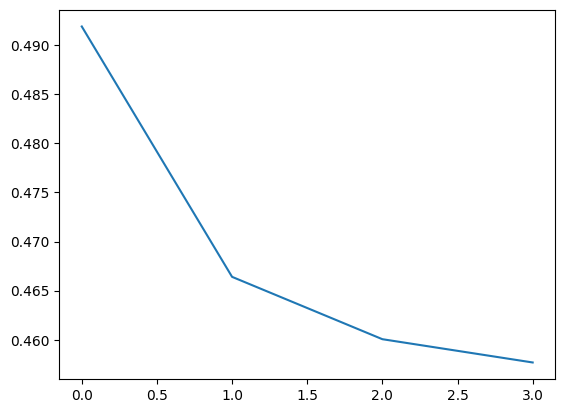

In [ ]:
plt.plot(test_loss_graph)

In [ ]:
approach_to_segment(np.random.uniform(-5, 5, (segment_size, vector_size)), 3, embeddings_model, net)

['to', 'plinio', 'cronología', 'abnormally', 'nknown', 'illiquidity']